# Model Selection

## Objective - To predict 4D results with the best model

In [1]:
# Import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

SEED = 0

### Step 1: Load in the required data

In [2]:
# Concatenate 3 CSV files from web scraping

df = pd.concat(
    map(pd.read_csv, ['webscraping1.csv', 'webscraping2.csv', 'webscraping3.csv']), ignore_index=True)
df.head(10)

,day,number,prize
0,"Wed, 24 Jun 2020",0,Consolation Prize
1,"Sun, 21 Feb 2016",0,Consolation Prize
2,"Wed, 20 Jan 2016",0,Consolation Prize
3,"Sun, 05 Oct 2014",0,First Prize
4,"Sat, 06 Sep 2014",0,Second Prize
5,"Sat, 26 Oct 2013",0,Starter Prize
6,"Sun, 29 Jan 2012",0,Starter Prize
7,"Sat, 06 Aug 2011",0,Consolation Prize
8,"Sat, 13 Jun 2009",0,Consolation Prize
9,"Sun, 14 May 2006",0,Starter Prize


### Step 2: Data Pre-processing and Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110339 entries, 0 to 110338
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   day     110339 non-null  object
 1   number  110339 non-null  int64 
 2   prize   110339 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [4]:
# Convert the 'number' column from numeric to fixed length string type (i.e. 4 digits)

df['number'] = df['number'].map('{0:04d}'.format)
df.head(10)

,day,number,prize
0,"Wed, 24 Jun 2020",0000,Consolation Prize
1,"Sun, 21 Feb 2016",0000,Consolation Prize
2,"Wed, 20 Jan 2016",0000,Consolation Prize
3,"Sun, 05 Oct 2014",0000,First Prize
4,"Sat, 06 Sep 2014",0000,Second Prize
5,"Sat, 26 Oct 2013",0000,Starter Prize
6,"Sun, 29 Jan 2012",0000,Starter Prize
7,"Sat, 06 Aug 2011",0000,Consolation Prize
8,"Sat, 13 Jun 2009",0000,Consolation Prize
9,"Sun, 14 May 2006",0000,Starter Prize


In [5]:
# Confirm 10,000 numbers in total

df['number'].nunique()

10000

In [6]:
# Split the 'day' column as 'day of week' and 'date' columns

df[['day_of_week', 'date']] = df['day'].str.split(', ', expand=True)
df.head(10)

,day,number,prize,day_of_week,date
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,24 Jun 2020
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,21 Feb 2016
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,20 Jan 2016
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,05 Oct 2014
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,06 Sep 2014
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,26 Oct 2013
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,29 Jan 2012
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,06 Aug 2011
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,13 Jun 2009
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,14 May 2006


In [7]:
# Convert the 'date' column to datetime

df['date'] = pd.to_datetime(df['date'])
df.head(10)

,day,number,prize,day_of_week,date
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,2020-06-24
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,2016-02-21
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,2016-01-20
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,2014-10-05
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,2014-09-06
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,2013-10-26
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,2012-01-29
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,2011-08-06
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,2009-06-13
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,2006-05-14


In [8]:
# Filter the 'date' column to remove data on 2021-6-6 due to partial scraping on that day

df = df[(df['date'] < '2021-6-6')]
df.count()

day            110322
number         110322
prize          110322
day_of_week    110322
date           110322
dtype: int64

In [9]:
# Return counts of unique days of week
# Only 1 draw on Thu, 25 Jan 2001, which replaced the draw on Wed, 24 Jan 2001
# Less draws on Wed (first draw in 1993) than Sat and Sun (first draws in 1986)

df['day_of_week'].value_counts()

Sat    41783
Sun    41744
Wed    26772
Thu       23
Name: day_of_week, dtype: int64

In [10]:
# Replace 'Thu' with 'Wed'

df['day_of_week'].replace({'Thu': 'Wed'}, inplace=True)
df['day_of_week'].value_counts()

Sat    41783
Sun    41744
Wed    26795
Name: day_of_week, dtype: int64

In [11]:
# Convert the 'date' column to the month abbreviated name format under 'month' column

df['month'] = df['date'].dt.strftime('%b')
df.head(10)

,day,number,prize,day_of_week,date,month
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,2020-06-24,Jun
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,2016-02-21,Feb
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,2016-01-20,Jan
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,2014-10-05,Oct
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,2014-09-06,Sep
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,2013-10-26,Oct
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,2012-01-29,Jan
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,2011-08-06,Aug
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,2009-06-13,Jun
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,2006-05-14,May


In [12]:
# Drop the redundant columns

df = df.drop(['day', 'date'], axis=1)
df.head(10)

,number,prize,day_of_week,month
0,0000,Consolation Prize,Wed,Jun
1,0000,Consolation Prize,Sun,Feb
2,0000,Consolation Prize,Wed,Jan
3,0000,First Prize,Sun,Oct
4,0000,Second Prize,Sat,Sep
5,0000,Starter Prize,Sat,Oct
6,0000,Starter Prize,Sun,Jan
7,0000,Consolation Prize,Sat,Aug
8,0000,Consolation Prize,Sat,Jun
9,0000,Starter Prize,Sun,May


In [13]:
# Return counts of unique prizes

df['prize'].value_counts()

Consolation Prize    47980
Starter Prize        47948
Second Prize          4798
First Prize           4798
Third Prize           4798
Name: prize, dtype: int64

In [14]:
# Return counts of unique numbers

new_list = df['number'].value_counts().sort_values(ascending=True)
new_list.head(20)

6190    1
6959    2
2982    2
8293    2
7705    2
7901    2
6061    2
6212    2
0057    2
5675    2
7161    3
4168    3
3545    3
1563    3
0621    3
8245    3
7147    3
2532    3
9889    3
2713    3
Name: number, dtype: int64

In [15]:
df.isna().any()

number         False
prize          False
day_of_week    False
month          False
dtype: bool

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110322 entries, 0 to 110338
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   number       110322 non-null  object
 1   prize        110322 non-null  object
 2   day_of_week  110322 non-null  object
 3   month        110322 non-null  object
dtypes: object(4)
memory usage: 4.2+ MB


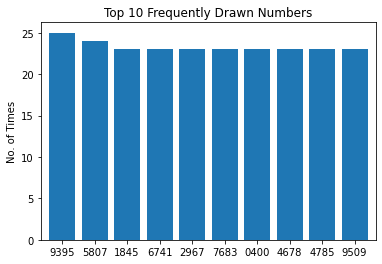

In [17]:
s = df['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Frequently Drawn Numbers")
plt.show()

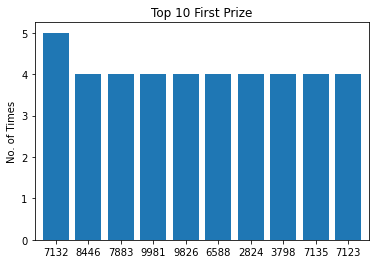

In [18]:
t = df[df['prize'].isin(['First Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 First Prize")
plt.show()

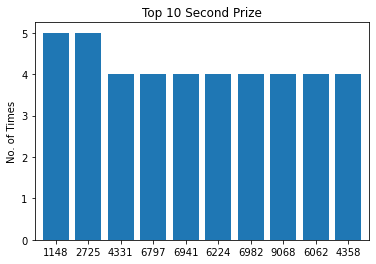

In [19]:
t = df[df['prize'].isin(['Second Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Second Prize")
plt.show()

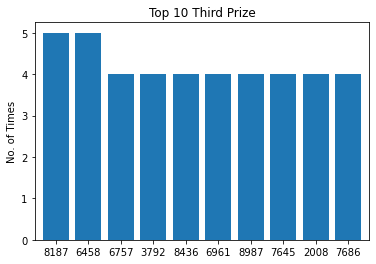

In [20]:
t = df[df['prize'].isin(['Third Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Third Prize")
plt.show()

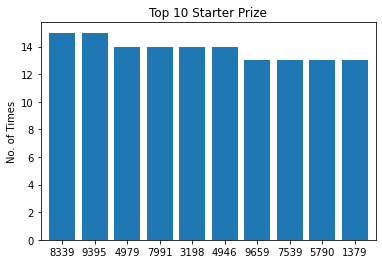

In [21]:
t = df[df['prize'].isin(['Starter Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Starter Prize")
plt.show()

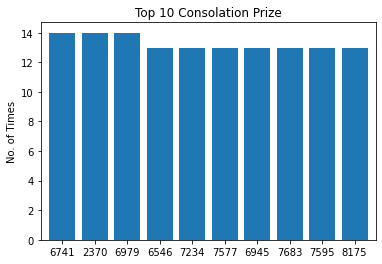

In [22]:
t = df[df['prize'].isin(['Consolation Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Consolation Prize")
plt.show()

In [23]:
# Split into 4 digits
# Use first digit as Class (from 10,000 classes reduced to 10 classes)

df['num1'] = df['number'].str[0:1]
df['num2'] = df['number'].str[1:2]
df['num3'] = df['number'].str[2:3]
df['num4'] = df['number'].str[3:4]

In [24]:
df = df.drop(['number'], axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110322 entries, 0 to 110338
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   prize        110322 non-null  object
 1   day_of_week  110322 non-null  object
 2   month        110322 non-null  object
 3   num1         110322 non-null  object
 4   num2         110322 non-null  object
 5   num3         110322 non-null  object
 6   num4         110322 non-null  object
dtypes: object(7)
memory usage: 6.7+ MB


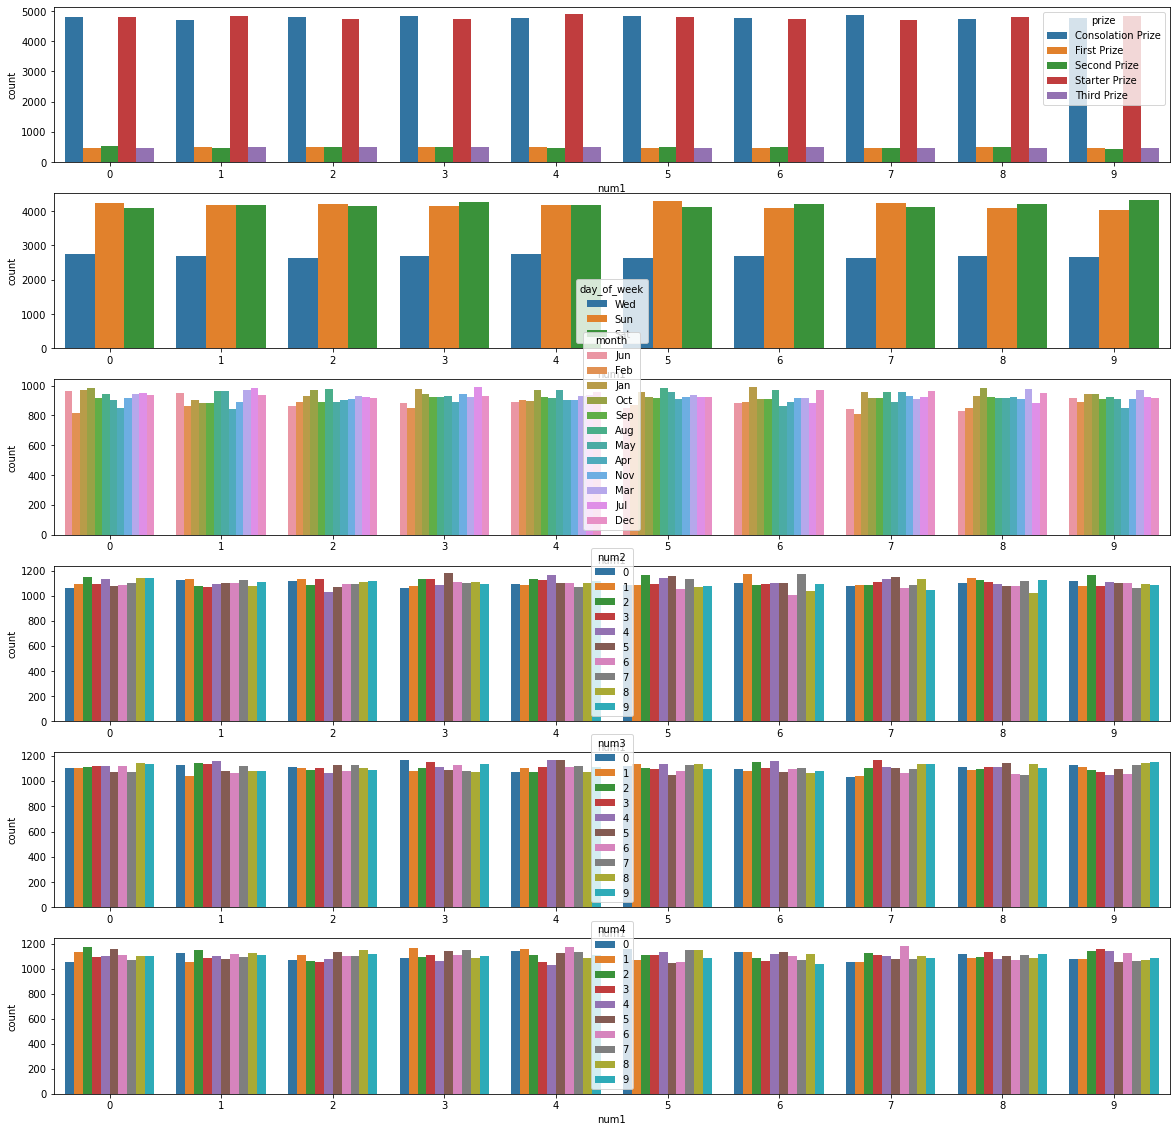

In [26]:
# Let's look at all the categorical variables and their impact on the numbers

# Removing number variable for analysis
categorical_var = [i for i in df.columns]
catVars_nonum1 = categorical_var[:3] + categorical_var[4:]

fig ,ax = plt.subplots(6,1,figsize=(20,20))
for axi ,var in zip(ax.flat,catVars_nonum1):
    sns.countplot(x=df.num1,hue=df[var],ax=axi)

In [27]:
# Encode variables with more than 2 Classes

df = pd.get_dummies(df, columns= ['prize', 'day_of_week', 'month', 'num2', 'num3', 'num4'], drop_first=True)

In [28]:
df['num1'] = pd.to_numeric(df['num1'])

### ROC Curve

In [29]:
X=df.drop('num1',axis=1)
y=df['num1']

In [30]:
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = 10

In [31]:
# Split the Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = SEED)

In [32]:
scaler = StandardScaler()

# Fit only to the training data

scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler()

In [33]:
# Now apply the transformations to the data

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Classifier

clf = OneVsRestClassifier(LogisticRegression())
y_score = clf.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

In [35]:
# Compute ROC curve and ROC area for each class

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = roc_auc_score(y_test[:,i], y_score[:,i], multi_class='ovr')

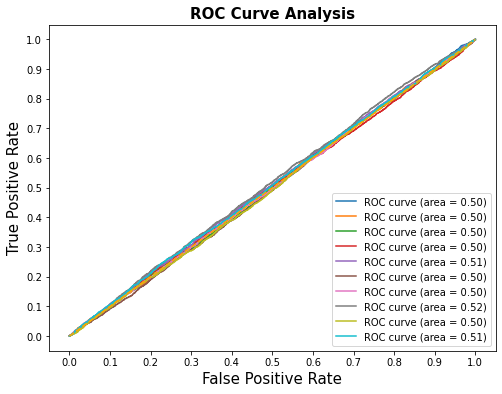

In [36]:
# Plot the figure

fig = plt.figure(figsize=(8,6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %.2f)' % roc_auc[i])
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks(np.arange(0.0, 1.1, step=0.1))

plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

#fig.savefig('Multiclass ROC.png')
plt.show()